Checkpoint: /workspace/hisnegs/src/checkpoints/mip_ckpt/e2e_ep400.pt
  Epoch  : 400,  K = 87832


  Volume loaded: (100, 647, 813), range [0.000, 1.000]
  PSNR = 32.16 dB


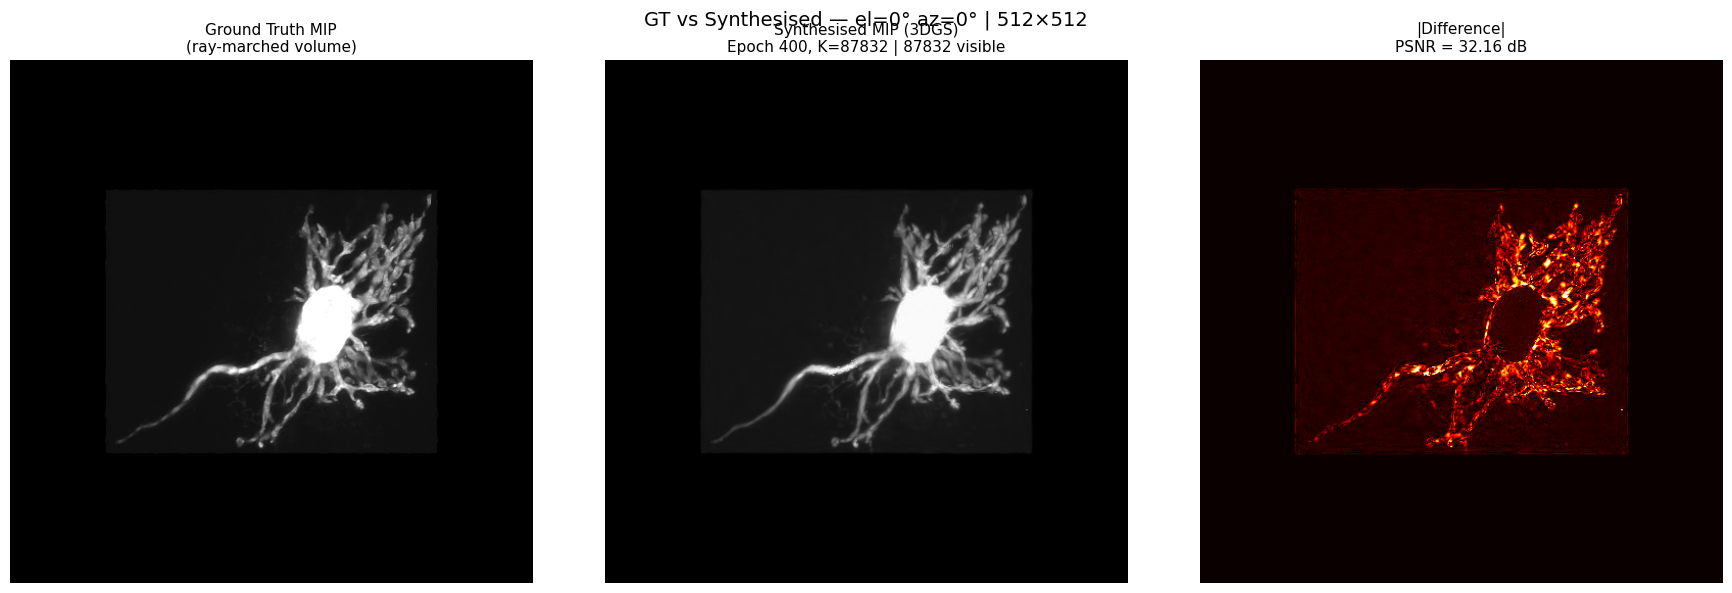

In [8]:
"""
Load trained 3DGS model and render synthesised MIP vs ground-truth MIP
from the same viewpoint.
"""
import sys, os, math
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath(".."))

from rendering import (
    Camera, GaussianParameters,
    compute_aspect_scales, apply_aspect_correction,
    render_mip_projection, render_gt_mip,
    load_volume, load_config, _orbit_pose,
    psnr_metric,
)

# ── 1. Load checkpoint ──────────────────────────────────────────────
ckpt_path = "/workspace/hisnegs/src/checkpoints/mip_ckpt/e2e_ep400.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(ckpt_path, map_location=device)
print(f"Checkpoint: {ckpt_path}")
print(f"  Epoch  : {checkpoint['epoch']},  K = {checkpoint['means'].shape[0]}")

means           = checkpoint["means"].to(device)
log_scales      = checkpoint["log_scales"].to(device)
quaternions     = checkpoint["quaternions"].to(device)
log_intensities = checkpoint["log_intensities"].to(device)
K = means.shape[0]

# ── 2. Build covariances ────────────────────────────────────────────
scales = torch.exp(log_scales).clamp(1e-5, 1e2)
q = F.normalize(quaternions, p=2, dim=-1)
w, x, y, z = q[:, 0], q[:, 1], q[:, 2], q[:, 3]
R = torch.zeros(K, 3, 3, device=device)
R[:, 0, 0] = 1-2*(y*y+z*z);  R[:, 0, 1] = 2*(x*y-w*z);  R[:, 0, 2] = 2*(x*z+w*y)
R[:, 1, 0] = 2*(x*y+w*z);    R[:, 1, 1] = 1-2*(x*x+z*z); R[:, 1, 2] = 2*(y*z-w*x)
R[:, 2, 0] = 2*(x*z-w*y);    R[:, 2, 1] = 2*(y*z+w*x);   R[:, 2, 2] = 1-2*(x*x+y*y)
S2  = torch.diag_embed(scales ** 2)
cov = R @ S2 @ R.transpose(-2, -1)
intensities = torch.sigmoid(log_intensities)

# ── 3. Camera & aspect correction ───────────────────────────────────
cfg = load_config("config_splat.yml")
vol_shape = (100, 647, 813)
aspect_scales = compute_aspect_scales(vol_shape).to(device)

gaussians = GaussianParameters(means=means, covariances=cov, intensities=intensities)
gaussians = apply_aspect_correction(gaussians, aspect_scales)

res = 512
camera = Camera.from_config(cfg, width=res, height=res)
beta = cfg["training"]["beta_mip"]
radius = cfg["poses"]["radius"]

# ── 4. Load volume for GT MIP ───────────────────────────────────────
vol_path = "/workspace/hisnegs/dataset/10-2900-control-cell-05_cropped_corrected.tif"
vol_np = load_volume(vol_path)
vol_gpu = torch.from_numpy(vol_np).float().to(device)
print(f"  Volume loaded: {vol_np.shape}, range [{vol_np.min():.3f}, {vol_np.max():.3f}]")

rm = cfg["ray_marching"]

# ── 5. Render synthesised + GT from same viewpoint ──────────────────
el, az = 0, 0
R_cam, T_cam = _orbit_pose(el, az, radius)
R_cam, T_cam = R_cam.to(device), T_cam.to(device)

with torch.no_grad():
    # Synthesised (3DGS)
    img_synth, n_vis = render_mip_projection(
        gaussians, camera, R_cam, T_cam,
        beta=beta, chunk_size=4096,
    )
    # Ground truth (ray-marched volume MIP)
    img_gt = render_gt_mip(
        vol_gpu, camera, R_cam, T_cam,
        n_samples=rm["n_samples"], near=rm["near"], far=rm["far"],
        aspect_scales=aspect_scales,
    )

synth_np = img_synth.cpu().numpy()
gt_np    = img_gt.cpu().numpy()

# Normalise for display
synth_disp = synth_np / (synth_np.max() + 1e-8)
gt_disp    = gt_np / (gt_np.max() + 1e-8)
diff_np    = np.abs(synth_disp - gt_disp)

# PSNR
psnr_val = float(psnr_metric(img_synth, img_gt))
print(f"  PSNR = {psnr_val:.2f} dB")

# ── 6. Plot ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(gt_disp, cmap="gray", vmin=0, vmax=1)
axes[0].set_title(f"Ground Truth MIP\n(ray-marched volume)", fontsize=11)
axes[0].axis("off")

axes[1].imshow(synth_disp, cmap="gray", vmin=0, vmax=1)
axes[1].set_title(f"Synthesised MIP (3DGS)\nEpoch {checkpoint['epoch']}, K={K} | {n_vis} visible", fontsize=11)
axes[1].axis("off")

axes[2].imshow(diff_np, cmap="hot", vmin=0, vmax=0.3)
axes[2].set_title(f"|Difference|\nPSNR = {psnr_val:.2f} dB", fontsize=11)
axes[2].axis("off")

fig.suptitle(f"GT vs Synthesised — el={el}° az={az}° | {res}×{res}", fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
"""
Compute total loss for the current checkpoint at (el=0, az=0).
Uses the same composite loss as training: weighted MSE + 0.2*SSIM + 0.1*edge + scale_reg
"""
sys.path.insert(0, "/workspace/hisnegs/src/renderer")
from end2end import compute_view_loss

loss_cfg = cfg["loss"]

# Need grad-enabled log_scales for scale_reg term
log_scales_grad = log_scales.clone().requires_grad_(False)

loss_val, metrics = compute_view_loss(
    pred=img_synth,
    target=img_gt,
    log_scales=log_scales_grad,
    fg_weight=loss_cfg["fg_weight"],
    lambda_ssim=loss_cfg["lambda_ssim"],
    lambda_edge=loss_cfg["lambda_edge"],
    lambda_scale=loss_cfg["lambda_scale"],
    scale_min=loss_cfg["scale_min"],
    lambda_scale_max=loss_cfg["lambda_scale_max"],
    scale_max=loss_cfg["scale_max"],
)

print(f"=== Loss breakdown (el=0°, az=0°) ===")
for k, v in metrics.items():
    print(f"  {k:12s}: {v:.6f}")
print(f"\n  Total loss : {metrics['loss']:.6f}")
print(f"  PSNR       : {metrics['psnr']:.2f} dB")
print(f"  SSIM       : {metrics['ssim']:.4f}")

=== Loss breakdown (el=0°, az=0°) ===
  loss        : 0.006586
  mse         : 0.001623
  psnr        : 32.157394
  ssim        : 0.975585
  scale_reg   : 0.000020

  Total loss : 0.006586
  PSNR       : 32.16 dB
  SSIM       : 0.9756


Camera: 1028×1028, fx=1102.3
Rendering 120 frames at 1028×1028, el=15.0°, az=[0°..360°) ...


  30/120 frames rendered
  60/120 frames rendered
  90/120 frames rendered
  120/120 frames rendered
All 120 frames rendered. Saving GIF...
GIF saved → ../checkpoints/mip_ckpt/e2e_rotate360_1028.gif  (16650 KB)


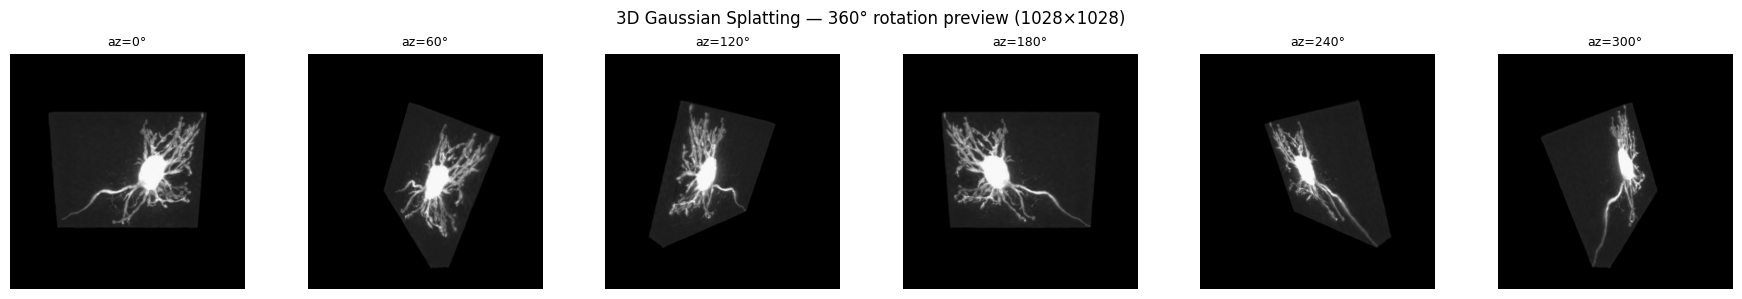

In [ ]:
"""
Generate a 360° Y-axis rotation GIF of the 3D Gaussian Splatting model at 1028×1028.
"""
import imageio
from pathlib import Path

# ── Re-build camera at higher resolution ──
hi_res = 1028
camera_hi = Camera.from_config(cfg, width=hi_res, height=hi_res)
print(f"Camera: {hi_res}×{hi_res}, fx={camera_hi.fx:.1f}")

n_frames = 120
fps = 24
elevation = 15.0
out_path = Path("../checkpoints/mip_ckpt/e2e_rotate360_1028.gif")
out_path.parent.mkdir(parents=True, exist_ok=True)

frames = []
azimuths = np.linspace(0, 360, n_frames, endpoint=False)

print(f"Rendering {n_frames} frames at {hi_res}×{hi_res}, el={elevation}°, az=[0°..360°) ...")

with torch.no_grad():
    for i, az in enumerate(azimuths):
        R_cam, T_cam = _orbit_pose(elevation, float(az), radius)
        R_cam = R_cam.to(device)
        T_cam = T_cam.to(device)

        img, _ = render_mip_projection(
            gaussians, camera_hi, R_cam, T_cam,
            beta=beta, chunk_size=4096,
        )

        img_np = img.detach().cpu().numpy()
        img_np = np.clip(img_np / (img_np.max() + 1e-8), 0, 1)
        frame = (img_np * 255).astype(np.uint8)
        frames.append(frame)

        if (i + 1) % 30 == 0:
            print(f"  {i+1}/{n_frames} frames rendered")

print(f"All {n_frames} frames rendered. Saving GIF...")
imageio.mimsave(str(out_path), frames, fps=fps, loop=0)
print(f"GIF saved → {out_path}  ({out_path.stat().st_size / 1024:.0f} KB)")

# Preview strip
preview_idx = list(range(0, n_frames, n_frames // 6))
fig, axes = plt.subplots(1, len(preview_idx), figsize=(18, 3))
for j, idx in enumerate(preview_idx):
    axes[j].imshow(frames[idx], cmap="gray")
    axes[j].set_title(f"az={azimuths[idx]:.0f}°", fontsize=9)
    axes[j].axis("off")
fig.suptitle(f"3D Gaussian Splatting — 360° rotation preview ({hi_res}×{hi_res})", fontsize=12)
plt.tight_layout()
plt.show()
